# Audible Data Science technical challenge

## Movie Rating Prediction using IMDB Datasets

Use the publicly available IMDB Datasets to build a model that predicts a movie’s average rating.

### 1. Data Gathering

> The dataset files can be accessed and downloaded from https://datasets.imdbws.com/. The data is refreshed daily.

Web-scraping the datasets from the dataset page and storing them in the `data` folder

In [1]:
import os
import requests

In [2]:
# !pip install beautifulsoup4

In [3]:
from bs4 import BeautifulSoup

In [4]:
url = "https://datasets.imdbws.com"
folder = "data"

In [5]:
# Make the data directory if it doesn't exist
if not os.path.isdir(folder):
    os.mkdir(folder)

# Send request
response = requests.get(url)
response.raise_for_status()  # Raise exception if invalid response

# Parse HTML
soup = BeautifulSoup(response.text, 'html.parser')

# Find and download all datasets
for link in soup.find_all('a'):
    href = link.get('href')
    if href.endswith('.tsv.gz'):
        print(f"Downloading {href} ...")

        # Send request
        r = requests.get(href, stream=True)
        r.raise_for_status()  # Raise exception if invalid response

        # Download to file
        with open(os.path.join(folder, os.path.basename(href)), 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)

print("Download completed!")

Download completed!


### 2. Data Preprocessing

In [6]:
import pandas as pd
import numpy as np

#### Load the data

> Each dataset is contained in a gzipped, tab-separated-values (TSV) formatted file in the UTF-8 character set. The first line in each file contains headers that describe what is in each column. A `\N` is used to denote that a particular field is missing or null for that title/name.

Loading only few datasets because of resource limitation

In [7]:
title_basics = pd.read_csv('data/title.basics.tsv.gz', sep='\t', na_values='\\N')
title_basics.head()

<ipython-input-7-14af40f4879b>:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  title_basics = pd.read_csv('data/title.basics.tsv.gz', sep='\t', na_values='\\N')


,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0.0,1894.0,NaN,1.0,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0.0,1892.0,NaN,5.0,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0.0,1892.0,NaN,4.0,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0.0,1892.0,NaN,12.0,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0.0,1893.0,NaN,1.0,"Comedy,Short"


In [8]:
title_ratings = pd.read_csv('data/title.ratings.tsv.gz', sep='\t', na_values='\\N')
title_ratings.head()

,tconst,averageRating,numVotes
0,tt0000001,5.7,1990
1,tt0000002,5.8,265
2,tt0000003,6.5,1853
3,tt0000004,5.5,178
4,tt0000005,6.2,2638


#### Merge datasets

In [9]:
titles = title_basics.merge(title_ratings, on='tconst')
titles.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
0,tt0000001,short,Carmencita,Carmencita,0.0,1894.0,NaN,1.0,"Documentary,Short",5.7,1990
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0.0,1892.0,NaN,5.0,"Animation,Short",5.8,265
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0.0,1892.0,NaN,4.0,"Animation,Comedy,Romance",6.5,1853
3,tt0000004,short,Un bon bock,Un bon bock,0.0,1892.0,NaN,12.0,"Animation,Short",5.5,178
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0.0,1893.0,NaN,1.0,"Comedy,Short",6.2,2638


#### Filter the relevant data

Checking the types of titles in the dataset

In [10]:
# Get counts of each title type
titles['titleType'].value_counts()

tvEpisode       656789
movie           294843
short           149239
tvSeries         88678
tvMovie          50946
video            50555
tvMiniSeries     15333
videoGame        14951
tvSpecial        11314
tvShort           2169
Name: titleType, dtype: int64

Not all titles are movies. Therefore, filtering the data to include only movies (`titleType` is 'movie')

Assuming, we are predicting only for movies (not considering tvmovies)

In [11]:
movies = titles[titles['titleType'] == 'movie']
movies.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
8,tt0000009,movie,Miss Jerry,Miss Jerry,0.0,1894.0,NaN,45.0,Romance,5.3,206
144,tt0000147,movie,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,0.0,1897.0,NaN,100.0,"Documentary,News,Sport",5.3,480
333,tt0000502,movie,Bohemios,Bohemios,0.0,1905.0,NaN,100.0,NaN,4.1,15
365,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0.0,1906.0,NaN,70.0,"Action,Adventure,Biography",6.0,840
373,tt0000591,movie,The Prodigal Son,L'enfant prodigue,0.0,1907.0,NaN,90.0,Drama,4.4,20


Checking for the type of features and null values

In [12]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 294843 entries, 8 to 1334812
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   tconst          294843 non-null  object 
 1   titleType       294843 non-null  object 
 2   primaryTitle    294843 non-null  object 
 3   originalTitle   294843 non-null  object 
 4   isAdult         294843 non-null  float64
 5   startYear       294808 non-null  float64
 6   endYear         0 non-null       float64
 7   runtimeMinutes  265792 non-null  object 
 8   genres          284716 non-null  object 
 9   averageRating   294843 non-null  float64
 10  numVotes        294843 non-null  int64  
dtypes: float64(4), int64(1), object(6)
memory usage: 27.0+ MB


#### Handling null values

In [13]:
movies.isnull().sum()

tconst                 0
titleType              0
primaryTitle           0
originalTitle          0
isAdult                0
startYear             35
endYear           294843
runtimeMinutes     29051
genres             10127
averageRating          0
numVotes               0
dtype: int64

Missing values are present in four features
1. `startYear`
2. `endYear`
3. `runtimeMinutes`
4. `genres`

`startYear`: Since there are very few missing values in this column, we can fill them with the median of the rest of the column



In [14]:
movies['startYear'] = movies['startYear'].fillna(movies['startYear'].median())

<ipython-input-14-4c890e63ad4b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies['startYear'] = movies['startYear'].fillna(movies['startYear'].median())


`endYear`: This column has no non-null values at all. It's likely this field is not useful for the prediction, let's drop the feature



In [15]:
movies = movies.drop(columns='endYear')

In [16]:
movies.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,runtimeMinutes,genres,averageRating,numVotes
8,tt0000009,movie,Miss Jerry,Miss Jerry,0.0,1894.0,45.0,Romance,5.3,206
144,tt0000147,movie,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,0.0,1897.0,100.0,"Documentary,News,Sport",5.3,480
333,tt0000502,movie,Bohemios,Bohemios,0.0,1905.0,100.0,NaN,4.1,15
365,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0.0,1906.0,70.0,"Action,Adventure,Biography",6.0,840
373,tt0000591,movie,The Prodigal Son,L'enfant prodigue,0.0,1907.0,90.0,Drama,4.4,20


`runtimeMinutes`: Fill in the missing values with the median

I realized that the field is an object type, which suggests it might contain non-numeric values. We need to convert it to a numeric type, and then impute accordingly

In [17]:
movies['runtimeMinutes'] = pd.to_numeric(movies['runtimeMinutes'], errors='coerce')
movies['runtimeMinutes'] = movies['runtimeMinutes'].fillna(movies['runtimeMinutes'].median())

`genres`: There are several strategies to handle the missing values in this column:
1. Fill them with a placeholder value like 'Unknown'
2. Fill them with the top 3 genres of the director of the movie

Going with the first option since it is easy

**_If I had more time and resources_**, I would choose the second option.
1. Identify the director of each movie: Load the `title.crew.tsv.gz` dataset, which contains the directors of each title.
2. For each director, identify their top 3 genres: Examine all the movies they've directed and the genres of those movies. We could create a DataFrame where each row corresponds to a director, and the columns contain the count of each genre. Then, for each director, you can find the top 3 genres.
3. Impute the missing genres of a movie with the top 3 genres of its director: Now that you have the top 3 genres of each director, we can use this information to fill in the missing genres of the movies they've directed.

In [18]:
movies['genres'] = movies['genres'].fillna('Unknown')

In [19]:
movies.isnull().sum()

tconst            0
titleType         0
primaryTitle      0
originalTitle     0
isAdult           0
startYear         0
runtimeMinutes    0
genres            0
averageRating     0
numVotes          0
dtype: int64

### 3. Exploratory Data Analysis

Let's find some answers to some of the questions using the plots and the data.

1. Is there a difference in average ratings between movies classified as 'adult' and those that are not?
2. Is there a trend or noticeable pattern between the release year of a movie and its average rating?
3. Does the length of a movie (runtime) influence its average rating? Are longer or shorter movies rated more highly?
4. Are certain genres more highly rated than others?
5. What is the distribution of the average ratings? Are most movies rated moderately or are there extremes?
6. Does the popularity of a movie (as measured by the number of votes) correlate with its average rating? Do more popular movies tend to have higher ratings?

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

In [21]:
movies.describe()

,isAdult,startYear,runtimeMinutes,averageRating,numVotes
count,294843.000000,294843.000000,294843.000000,294843.000000,2.948430e+05
mean,0.015656,1994.792608,94.094610,6.176877,3.611889e+03
std,0.124140,25.818309,132.058722,1.368113,3.546932e+04
min,0.000000,1894.000000,1.000000,1.000000,5.000000e+00
25%,0.000000,1979.000000,83.000000,5.400000,1.900000e+01
50%,0.000000,2005.000000,91.000000,6.300000,6.100000e+01
75%,0.000000,2015.000000,101.000000,7.100000,3.120000e+02
max,1.000000,2023.000000,51420.000000,10.000000,2.776726e+06


#### Correlation plot

<ipython-input-22-5cb789cce20a>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = movies.corr()


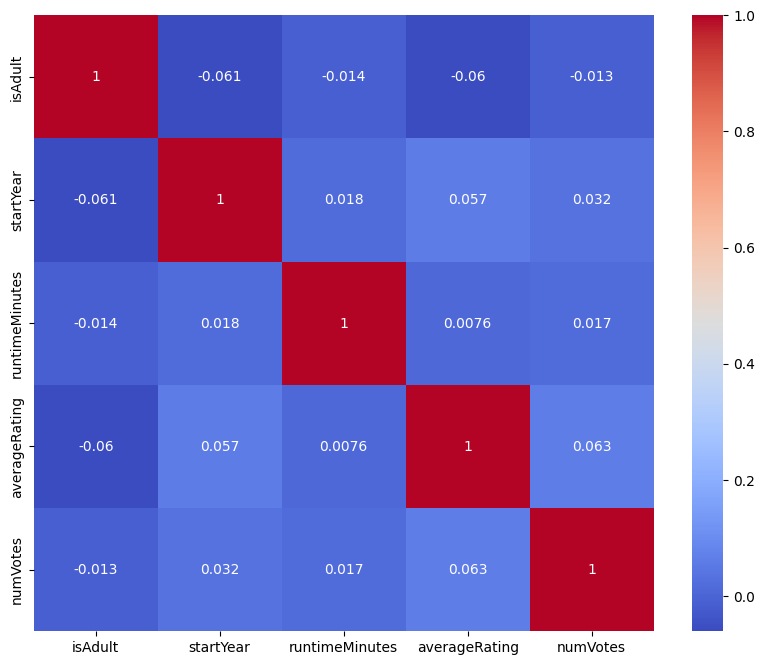

In [22]:
plt.figure(figsize=(10,8))
correlation_matrix = movies.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

From the correlation matrix, we can infer that

`isAdult` and `averageRating`: 'adult' movies tend to have slightly lower ratings, although the relationship is weak.

`startYear` and `averageRating`: more recent movies have slightly higher ratings, but again, this is a weak correlation.

`runtimeMinutes` and `averageRating`: longer movies might have slightly higher ratings, but the relationship is quite weak.

`numVotes` and `averageRating`: movies with more votes tend to have slightly higher ratings, although the correlation is weak.

#### Assumption 1. 'adult' movies tend to have slightly lower ratings

Is there a difference in average ratings between movies classified as 'adult' and those that are not?

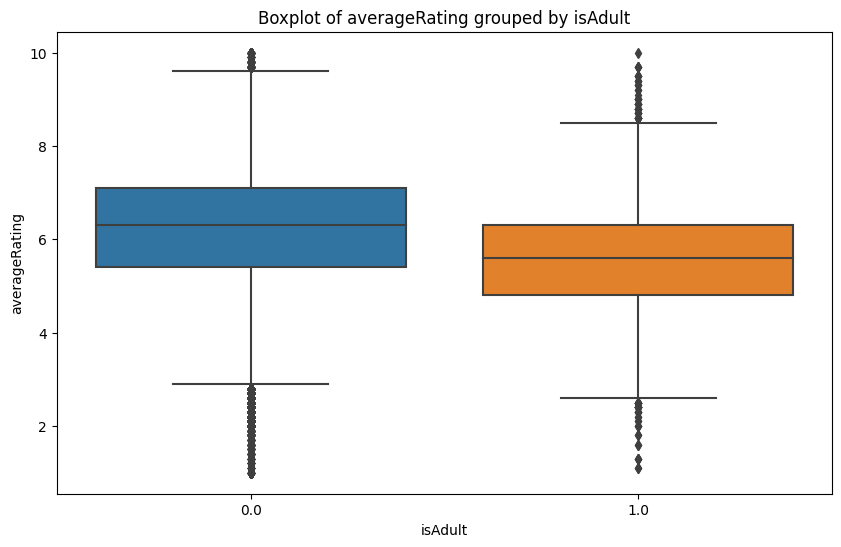

In [23]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='isAdult', y='averageRating', data=movies)
plt.title('Boxplot of averageRating grouped by isAdult')
plt.xlabel('isAdult')
plt.ylabel('averageRating')
plt.show()

In the box plot, the line in the middle of each box is the median rating for that category, while the box extends from the lower to upper quartile values of the data, giving the interquartile range. The whiskers extend to show the range of the data, and points outside of this range are considered to be outliers.

The medians and/or interquartile ranges differ significantly between the adult and non-adult movies, this could indicate a correlation between the `isAdult` and the `averageRating`.

#### Assumption 2. `averageRating` is normally distributed

What is the distribution of the average ratings? Are most movies rated moderately or are there extremes?

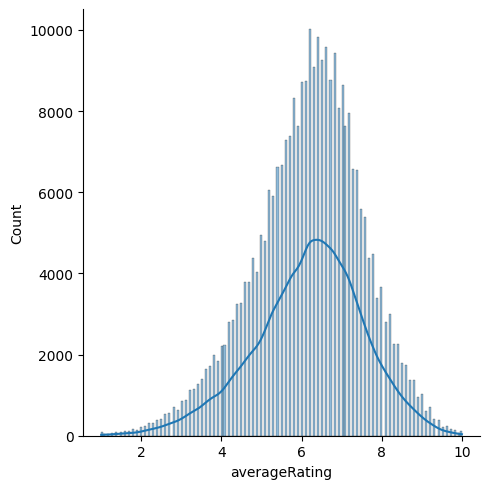

In [24]:
# create a histogram of averageRating
sns.displot(movies['averageRating'], kde=True)
plt.show()

`averageRating` is normally distributed. This implies that most movies receive a moderate rating, with few movies getting very low or very high ratings.

#### Assumption 3. `genres` affect the `averageRating`

Are certain genres more highly rated than others?

In [25]:
# Split the genres string into a list of strings
movies['genres'] = movies['genres'].apply(lambda x: x.split(","))

In [26]:
movies.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,runtimeMinutes,genres,averageRating,numVotes
8,tt0000009,movie,Miss Jerry,Miss Jerry,0.0,1894.0,45.0,[Romance],5.3,206
144,tt0000147,movie,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,0.0,1897.0,100.0,"[Documentary, News, Sport]",5.3,480
333,tt0000502,movie,Bohemios,Bohemios,0.0,1905.0,100.0,[Unknown],4.1,15
365,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0.0,1906.0,70.0,"[Action, Adventure, Biography]",6.0,840
373,tt0000591,movie,The Prodigal Son,L'enfant prodigue,0.0,1907.0,90.0,[Drama],4.4,20


In [27]:
# explode genres on movies
movies_exploded = movies.assign(genres=movies['genres']).explode('genres')

In [28]:
movies_exploded.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,runtimeMinutes,genres,averageRating,numVotes
8,tt0000009,movie,Miss Jerry,Miss Jerry,0.0,1894.0,45.0,Romance,5.3,206
144,tt0000147,movie,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,0.0,1897.0,100.0,Documentary,5.3,480
144,tt0000147,movie,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,0.0,1897.0,100.0,News,5.3,480
144,tt0000147,movie,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,0.0,1897.0,100.0,Sport,5.3,480
333,tt0000502,movie,Bohemios,Bohemios,0.0,1905.0,100.0,Unknown,4.1,15


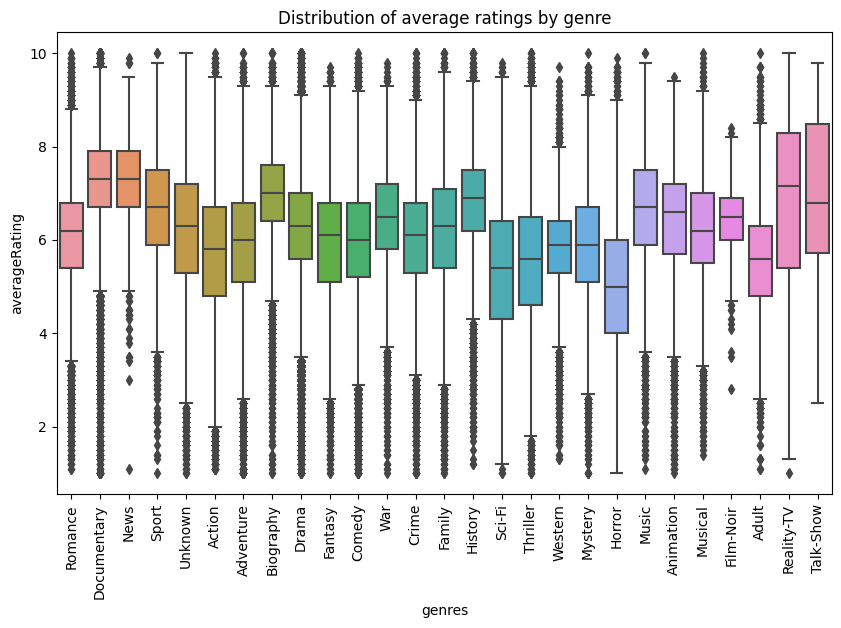

In [29]:
# box plot for avgRatings for each genre
plt.figure(figsize=(10,6))
sns.boxplot(x='genres', y='averageRating', data=movies_exploded)
plt.xticks(rotation=90)
plt.title('Distribution of average ratings by genre')
plt.show()

Based on this plot, there are some genres that have high score than others, which mean that genre definitely affect the movie rating.

**_If I had more time and resources_**, I would perform some more analysis on the featues and their relationships to answer a few more questions
4. Is there a trend or noticeable pattern between the release year of a movie and its average rating?
5. Does the length of a movie (runtime) influence its average rating? Are longer or shorter movies rated more highly?
6. Does the popularity of a movie (as measured by the number of votes) correlate with its average rating? Do more popular movies tend to have higher ratings?

### 4. Feature Engineering

#### One-hot encoding of Genres

Since we know that `genre` has an effect on the `averageRating`, let's use it as a feature but Machine learning models cannot work with categorical data, they require numerical inputs. We need to encode the `genres` into a numeric format.

The disadvantage of this process is it increases the dataset's size (adds more features).

Use `MultiLabelBinarizer` for one-hot encoding

In [30]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()

# One-hot encoding of genres
one_hot_genres = mlb.fit_transform(movies['genres'])

# Convert this array into a DataFrame
one_hot_genres_df = pd.DataFrame(one_hot_genres, columns=mlb.classes_)

one_hot_genres_df.head()

,Action,Adult,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,...,News,Reality-TV,Romance,Sci-Fi,Sport,Talk-Show,Thriller,Unknown,War,Western
0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,...,1,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,1,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
# Convert this array into a DataFrame and rename the columns
one_hot_genres_df = pd.DataFrame(one_hot_genres, columns=['genre_'+str(cls) for cls in mlb.classes_])

In [32]:
one_hot_genres_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294843 entries, 0 to 294842
Data columns (total 27 columns):
 #   Column             Non-Null Count   Dtype
---  ------             --------------   -----
 0   genre_Action       294843 non-null  int64
 1   genre_Adult        294843 non-null  int64
 2   genre_Adventure    294843 non-null  int64
 3   genre_Animation    294843 non-null  int64
 4   genre_Biography    294843 non-null  int64
 5   genre_Comedy       294843 non-null  int64
 6   genre_Crime        294843 non-null  int64
 7   genre_Documentary  294843 non-null  int64
 8   genre_Drama        294843 non-null  int64
 9   genre_Family       294843 non-null  int64
 10  genre_Fantasy      294843 non-null  int64
 11  genre_Film-Noir    294843 non-null  int64
 12  genre_History      294843 non-null  int64
 13  genre_Horror       294843 non-null  int64
 14  genre_Music        294843 non-null  int64
 15  genre_Musical      294843 non-null  int64
 16  genre_Mystery      294843 non-null  in

In [33]:
# Reset index of your main DataFrame and construct final DataFrame
movies.reset_index(drop=True, inplace=True)
movies = pd.concat([movies, one_hot_genres_df], axis=1)

movies.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,runtimeMinutes,genres,averageRating,numVotes,...,genre_News,genre_Reality-TV,genre_Romance,genre_Sci-Fi,genre_Sport,genre_Talk-Show,genre_Thriller,genre_Unknown,genre_War,genre_Western
0,tt0000009,movie,Miss Jerry,Miss Jerry,0.0,1894.0,45.0,[Romance],5.3,206,...,0,0,1,0,0,0,0,0,0,0
1,tt0000147,movie,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,0.0,1897.0,100.0,"[Documentary, News, Sport]",5.3,480,...,1,0,0,0,1,0,0,0,0,0
2,tt0000502,movie,Bohemios,Bohemios,0.0,1905.0,100.0,[Unknown],4.1,15,...,0,0,0,0,0,0,0,1,0,0
3,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0.0,1906.0,70.0,"[Action, Adventure, Biography]",6.0,840,...,0,0,0,0,0,0,0,0,0,0
4,tt0000591,movie,The Prodigal Son,L'enfant prodigue,0.0,1907.0,90.0,[Drama],4.4,20,...,0,0,0,0,0,0,0,0,0,0


In [34]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294843 entries, 0 to 294842
Data columns (total 37 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   tconst             294843 non-null  object 
 1   titleType          294843 non-null  object 
 2   primaryTitle       294843 non-null  object 
 3   originalTitle      294843 non-null  object 
 4   isAdult            294843 non-null  float64
 5   startYear          294843 non-null  float64
 6   runtimeMinutes     294843 non-null  float64
 7   genres             294843 non-null  object 
 8   averageRating      294843 non-null  float64
 9   numVotes           294843 non-null  int64  
 10  genre_Action       294843 non-null  int64  
 11  genre_Adult        294843 non-null  int64  
 12  genre_Adventure    294843 non-null  int64  
 13  genre_Animation    294843 non-null  int64  
 14  genre_Biography    294843 non-null  int64  
 15  genre_Comedy       294843 non-null  int64  
 16  ge

#### Dimensionality reduction

As of now, we are removing the redundant features

If I had more time and resources, I would perform Principal Component Analysis (PCA) to improve the performance of models

In [35]:
movies = movies.drop(columns='genres')

In [36]:
movies.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,runtimeMinutes,averageRating,numVotes,genre_Action,...,genre_News,genre_Reality-TV,genre_Romance,genre_Sci-Fi,genre_Sport,genre_Talk-Show,genre_Thriller,genre_Unknown,genre_War,genre_Western
0,tt0000009,movie,Miss Jerry,Miss Jerry,0.0,1894.0,45.0,5.3,206,0,...,0,0,1,0,0,0,0,0,0,0
1,tt0000147,movie,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,0.0,1897.0,100.0,5.3,480,0,...,1,0,0,0,1,0,0,0,0,0
2,tt0000502,movie,Bohemios,Bohemios,0.0,1905.0,100.0,4.1,15,0,...,0,0,0,0,0,0,0,1,0,0
3,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0.0,1906.0,70.0,6.0,840,1,...,0,0,0,0,0,0,0,0,0,0
4,tt0000591,movie,The Prodigal Son,L'enfant prodigue,0.0,1907.0,90.0,4.4,20,0,...,0,0,0,0,0,0,0,0,0,0


**_If I had more time and resources_**, I would explore the crew features by loading the other datasets. Create indicators for specific directors, writers or crew members who may be particularly influential.

This can be done by one-hot encoding the directors and writers columns. This, however, might result in a high dimensional data problem, so another approach might be to create a success score/popularity index for directors and writers based on the average ratings of their past movies. This can be treated as a measure of their past performance.

Similar to the success score/popularity index for directors and writers, you can create a measure of the success of the main actors/actresses based on the ratings of their past movies.

### 5. Model Training and Evaluation

Now that we have a proper dataset, we will be training and few models and testing them on unseen data to see how do they perform.

In [37]:
movies.set_index('tconst', inplace=True)

In [38]:
movies.head()

,titleType,primaryTitle,originalTitle,isAdult,startYear,runtimeMinutes,averageRating,numVotes,genre_Action,genre_Adult,...,genre_News,genre_Reality-TV,genre_Romance,genre_Sci-Fi,genre_Sport,genre_Talk-Show,genre_Thriller,genre_Unknown,genre_War,genre_Western
tconst,,,,,,,,,,,,,,,,,,,,,
tt0000009,movie,Miss Jerry,Miss Jerry,0.0,1894.0,45.0,5.3,206,0,0,...,0,0,1,0,0,0,0,0,0,0
tt0000147,movie,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,0.0,1897.0,100.0,5.3,480,0,0,...,1,0,0,0,1,0,0,0,0,0
tt0000502,movie,Bohemios,Bohemios,0.0,1905.0,100.0,4.1,15,0,0,...,0,0,0,0,0,0,0,1,0,0
tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0.0,1906.0,70.0,6.0,840,1,0,...,0,0,0,0,0,0,0,0,0,0
tt0000591,movie,The Prodigal Son,L'enfant prodigue,0.0,1907.0,90.0,4.4,20,0,0,...,0,0,0,0,0,0,0,0,0,0


In [39]:
# Get the list of columns and rearrange them
cols = movies.columns.tolist()
cols.remove('averageRating')
cols.insert(cols.index('originalTitle') + 1, 'averageRating')

# Reindex the dataframe
movies = movies[cols]

In [40]:
movies.head()

,titleType,primaryTitle,originalTitle,averageRating,isAdult,startYear,runtimeMinutes,numVotes,genre_Action,genre_Adult,...,genre_News,genre_Reality-TV,genre_Romance,genre_Sci-Fi,genre_Sport,genre_Talk-Show,genre_Thriller,genre_Unknown,genre_War,genre_Western
tconst,,,,,,,,,,,,,,,,,,,,,
tt0000009,movie,Miss Jerry,Miss Jerry,5.3,0.0,1894.0,45.0,206,0,0,...,0,0,1,0,0,0,0,0,0,0
tt0000147,movie,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,5.3,0.0,1897.0,100.0,480,0,0,...,1,0,0,0,1,0,0,0,0,0
tt0000502,movie,Bohemios,Bohemios,4.1,0.0,1905.0,100.0,15,0,0,...,0,0,0,0,0,0,0,1,0,0
tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,6.0,0.0,1906.0,70.0,840,1,0,...,0,0,0,0,0,0,0,0,0,0
tt0000591,movie,The Prodigal Son,L'enfant prodigue,4.4,0.0,1907.0,90.0,20,0,0,...,0,0,0,0,0,0,0,0,0,0


In [41]:
features = movies.loc[:, 'isAdult':]

features.head()

,isAdult,startYear,runtimeMinutes,numVotes,genre_Action,genre_Adult,genre_Adventure,genre_Animation,genre_Biography,genre_Comedy,...,genre_News,genre_Reality-TV,genre_Romance,genre_Sci-Fi,genre_Sport,genre_Talk-Show,genre_Thriller,genre_Unknown,genre_War,genre_Western
tconst,,,,,,,,,,,,,,,,,,,,,
tt0000009,0.0,1894.0,45.0,206,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
tt0000147,0.0,1897.0,100.0,480,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
tt0000502,0.0,1905.0,100.0,15,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
tt0000574,0.0,1906.0,70.0,840,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
tt0000591,0.0,1907.0,90.0,20,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [42]:
target = movies['averageRating']

target.head()

tconst
tt0000009    5.3
tt0000147    5.3
tt0000502    4.1
tt0000574    6.0
tt0000591    4.4
Name: averageRating, dtype: float64

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [44]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

#### Linear Regression

In [45]:
from sklearn.linear_model import LinearRegression

# instantiate and train the model
lr = LinearRegression()
lr.fit(X_train, y_train)

# make predictions
y_pred_lr = lr.predict(X_test)

# compute metrics
mse_lr = mean_squared_error(y_test, y_pred_lr)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)

print('Linear Regression:')
print('MSE:', mse_lr)
print('RMSE:', rmse_lr)
print('MAE:', mae_lr)
print('R²:', r2_lr)

Linear Regression:
MSE: 1.507695449914914
RMSE: 1.2278825065595298
MAE: 0.9449930956375117
R²: 0.1974564428087877


The Linear Regression model isn't performing very well. The MSE, RMSE, and MAE are fairly high. The low R² score for the Linear Regression model (0.1975) suggests that there may be a non-linear relationship between some of the features and the target variable, which the Linear Regression model can't capture.

#### Decision Trees

In [46]:
from sklearn.tree import DecisionTreeRegressor

# instantiate and train the model
dt = DecisionTreeRegressor()
dt.fit(X_train, y_train)

# make predictions
y_pred_dt = dt.predict(X_test)

# compute metrics
mse_dt = mean_squared_error(y_test, y_pred_dt)
mae_dt = mean_absolute_error(y_test, y_pred_dt)
r2_dt = r2_score(y_test, y_pred_dt)
rmse_dt = np.sqrt(mse_dt)

print('\nDecision Tree:')
print('MSE:', mse_dt)
print('RMSE:', rmse_dt)
print('MAE:', mae_dt)
print('R²:', r2_dt)


Decision Tree:
MSE: 2.623263663768436
RMSE: 1.6196492409680672
MAE: 1.2291842878354646
R²: -0.39635849686352986


The Decision Tree model seems to be performing worse than the Linear Regression model, as indicated by the higher MSE, RMSE, MAE and a negative R² score. The negative R² score for the Decision Tree model indicates that it is performing worse than a horizontal line fit to the data.

#### Random Forests

In [47]:
from sklearn.ensemble import RandomForestRegressor

# instantiate and train the model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# make predictions
y_pred_rf = rf.predict(X_test)

# compute metrics
mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)

print('\nRandom Forest:')
print('MSE:', mse_rf)
print('RMSE:', rmse_rf)
print('MAE:', mae_rf)
print('R²:', r2_rf)


Random Forest:
MSE: 1.4620150916392376
RMSE: 1.2091381606910094
MAE: 0.9154945585717896
R²: 0.22177201478083253


The Random Forest model is performing better than both the Linear Regression and Decision Tree models on the dataset. The MSE, RMSE, and MAE are lower than before, and the R² score is higher. This suggests that Random Forest is a more suitable model for your dataset as it is able to capture more complex relationships between the features and the target variable.



In [50]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [200, 500, 1000],
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_leaf': [4, 10, 50]
}

rf = RandomForestRegressor()

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


{'max_features': 'sqrt', 'min_samples_leaf': 4, 'n_estimators': 1000}
